# Telco Final Report

## Goal: 

* Discover Drivers of churn for Telco customers
* Use these drivers to create a machine learning model to predict if a customer will churn

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

from wrangle import get_telco_data, split_data, clean_telco
import os
from env import get_db_url

## Acquire

* Data was acquired from the codeup database's Telco dataset
* Data originally contained 7043 rows and 24 columns before cleaning
* Each row represents a customer for Telco
* Each column represents a feature of those customers

In [2]:
telco_df = get_telco_data()


## Prepare

* Removed columns that were not being examined in this report
* Checked for null values, there were none
* Checked column data types
* Created new column from payment_type column called billing_type that showed if client had automatic or manual payment methods
* Encoded categorical variables
* split data into train, validate, and test (60/20/20)
* no outliers removed for this iteration of the project
* selected 4 categories that seemed logically promising as drivers for churn: billing type, monthly charges, contract type, and whether the client has dependents or not.

In [3]:
# create new column for automatic vs manual billing
telco_df['billing_type'] = np.where(telco_df.payment_type.str.contains('automatic'), 'automatic', 'manual')

In [4]:
# perform above cleaning and dummy variable instructions on df
telco_df = clean_telco(telco_df)

In [5]:
# splits data into train, validate, and test sets
train, validate, test = split_data(telco_df, col_to_stratify='churn', random_state=7)
train.shape, validate.shape, test.shape


((4225, 10), (1409, 10), (1409, 10))

In [6]:
# splits into x and y for features and target variable on train, test, and validate
X_train = train.drop(columns=['dependents', 'contract_type', 'billing_type', 'churn', 'churn_Yes'])
y_train = train.churn_Yes

X_validate = validate.drop(columns=['dependents', 'contract_type', 'billing_type', 'churn', 'churn_Yes'])
y_validate = validate.churn_Yes

X_test = test.drop(columns=['dependents', 'contract_type', 'billing_type', 'churn', 'churn_Yes'])
y_test = test.churn_Yes

## Data Dictionary

 The following dictionary only defines columns used in analysis for this dataset.

| Feature | Definition |
|:--------|:-----------|
|Churn| True or False, Displays if a customer has churned or not|
|Monthly Charges| The amount in dollars a customer is charged each month|
|Billing Type| Way in which a customer pays bills: Automatic billing or Manual billing |
|Dependents| Yes or no category, does client have dependents?|

### Overall view of the data

In [31]:
telco_df.head().T

,0,1,2,3,4
dependents,Yes,No,No,No,No
monthly_charges,65.6,59.9,73.9,98.0,83.9
churn,No,No,Yes,Yes,Yes
contract_type,One year,Month-to-month,Month-to-month,Month-to-month,Month-to-month
billing_type,manual,manual,manual,manual,manual
dependents_Yes,1,0,0,0,0
contract_type_One year,1,0,0,0,0
contract_type_Two year,0,0,0,0,0
billing_type_manual,1,1,1,1,1
churn_Yes,0,0,1,1,1


### Summary of the data

In [32]:
telco_df.describe()

,monthly_charges,dependents_Yes,contract_type_One year,contract_type_Two year,billing_type_manual,churn_Yes
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,0.299588,0.209144,0.240664,0.564674,0.265370
std,30.090047,0.458110,0.406726,0.427517,0.495835,0.441561
min,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.500000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,70.350000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,89.850000,1.000000,0.000000,0.000000,1.000000,1.000000
max,118.750000,1.000000,1.000000,1.000000,1.000000,1.000000


## Explore

Establishing a baseline: how accurate would we be if we just always guessed the mode of the data?

In [7]:
def establish_baseline(y_train):
    '''
    This function establishes a baseline accuracy for comparison to a  model
    '''
    # this finds the mode of the train dataset
    baseline_prediction = y_train.mode()
    # this creates a prediction 
    y_train_pred = pd.Series((baseline_prediction[0]), range(len(y_train)))

    cm = confusion_matrix(y_train, y_train_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp+tn)/(tn+fp+fn+tp)
    return accuracy

In [8]:
establish_baseline(y_train)

0.7346745562130178

### Do monthly charges affect churn? 

Text(0.5, 1.0, 'Do Monthly Charges Affect Churn?')

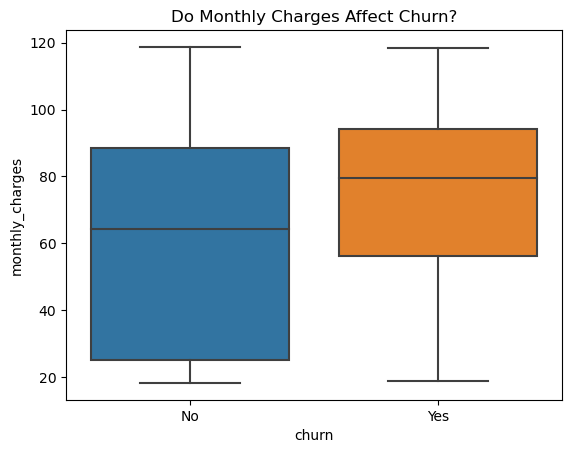

In [17]:
sns.boxplot(data=telco_df, y='monthly_charges', x='churn')
plt.title('Do Monthly Charges Affect Churn?')

It looks like there is a difference in mean charges between churn and no churn groups, but is this difference statistically significant? 

First, we must determine if monthly charges follow a normal distribution.

<Axes: xlabel='monthly_charges', ylabel='Count'>

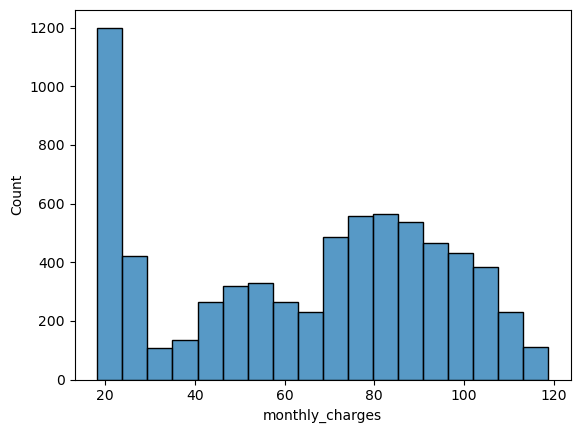

In [18]:
sns.histplot(telco_df.monthly_charges)

It does not appear that we can assume normality. Consequently, we will use a Mann Whitney test to compare means on a continuous variable. Based on the above box plot, we will hypothesize that churn rate is higher with those having higher monthly charges.

Ha: Customers who have churned are more likely to have higher monthly charges
Ho: There is no statistically significant difference in monthly charges between churn and no churn customers
alpha = .05

In [19]:
# here, we set means for the churn and no churn samples
no_churn_sample = telco_df[telco_df.churn=='No'].monthly_charges
churn_sample = telco_df[telco_df.churn=='Yes'].monthly_charges

mean_a = churn_sample.mean()
mean_b = no_churn_sample.mean()

In [20]:
# this runs a mann whitney test where the churn sample is hypothesized to be greater than the no churn sample
stat, p = stats.mannwhitneyu(churn_sample, no_churn_sample, alternative='greater')
stat, p

(6003125.5, 1.6558138259942924e-54)

The p value is less than the alpha. We may reject the null hypothesis. Churned customer monthly charges are statistically significantly higher, on average, than no churn customers. This indicates that monthly charges may be a good candidate for use in our model.

### Does billing type affect churn? 

Text(0.5, 1.0, 'Does Billing Type Affect Churn?')

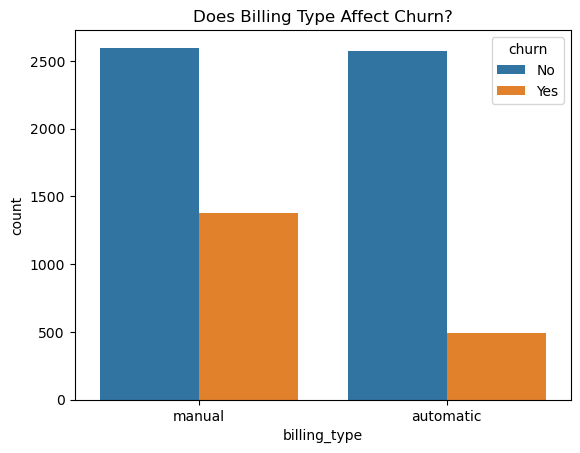

In [21]:
sns.countplot(x='billing_type', hue='churn', data=telco_df)
plt.title('Does Billing Type Affect Churn?')

I will use a chi square test to compare the categorical variables of churn and billing type

Ha: customers with manual billing have statistically significantly higher churn rate than those with automatic billing
Ho: There is no statistically significant different between manual and automatic billing means as regards churn status
alpha = .05

In [22]:
# we first create a crosstab of values for each category
observed = pd.crosstab(telco_df.churn, telco_df.billing_type)
observed

billing_type,automatic,manual
churn,,
No,2576,2598
Yes,490,1379


In [24]:
# we then calculate our p value 
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

3.0278725722860343e-69

The p value is less than the alpha. We may reject the null hypothesis. Customers with manual billing are statistically significantly more likely to churn than those with automatic billing. This indicates that billing type may be a good candidate for use in our model.

### Does contract type affect churn?

Text(0.5, 1.0, 'Does Contract Type Affect Churn?')

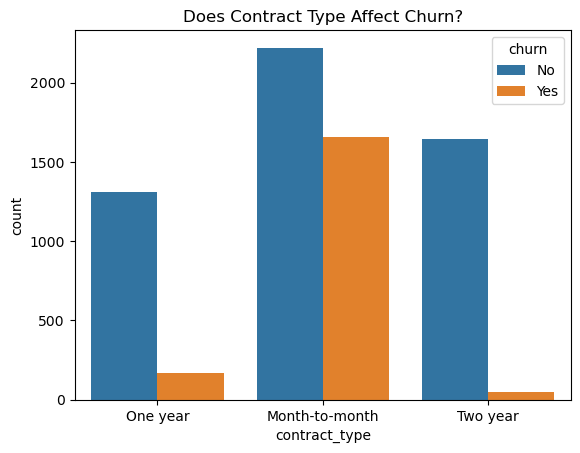

In [25]:
sns.countplot(x='contract_type', hue='churn', data=telco_df)
plt.title('Does Contract Type Affect Churn?')

I will use a chi square test to compare the categorical variables of churn and contract type

Ha: Contract type does have a relationship with churn
Ho: Contract type does not have a relationship with churn

In [26]:
# we first create a crosstab of values for each combination of categories
observed_contract = pd.crosstab(telco_df.churn, telco_df.contract_type)
observed_contract

contract_type,Month-to-month,One year,Two year
churn,,,
No,2220,1307,1647
Yes,1655,166,48


In [27]:
# we then calculate our p value 
chi2, p, degf, expected = stats.chi2_contingency(observed_contract)
p

5.863038300673391e-258

The p value is less than the alpha. We may reject the null hypothesis. Churn does have a statistically significant relationship to contract type. This indicates that contract type may be a good candidate for use in our model.

### Does having dependents have an effect on churn? 

Text(0.5, 1.0, 'Does Having Dependents Affect Churn?')

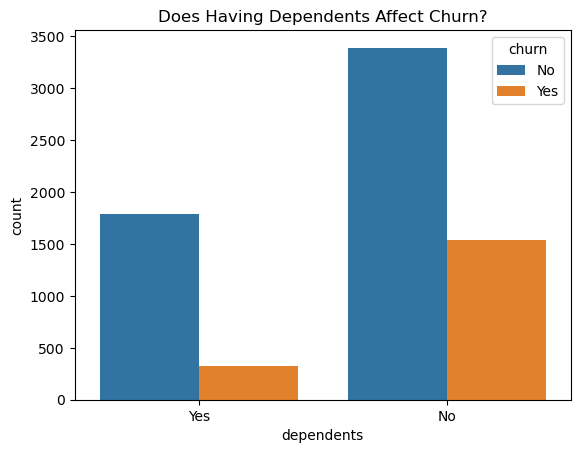

In [28]:
sns.countplot(x='dependents', hue='churn', data=telco_df)
plt.title('Does Having Dependents Affect Churn?')

I will use a chi square test to compare the categorical variables of churn and possession of dependents

Ha: There is a statistically significant difference between those with dependents and those without when it comes to churn

Ho: There is no statistically significant difference between those with and without dependents when it comes to churn

In [29]:
# we first create a crosstab of values for each combination of categories
observed_dependents = pd.crosstab(telco_df.churn, telco_df.dependents)
observed_dependents

dependents,No,Yes
churn,,
No,3390,1784
Yes,1543,326


In [30]:
# we then calculate our p value 
chi2, p, degf, expected = stats.chi2_contingency(observed_dependents)
p

4.9249216612154196e-43

The p value is less than the alpha. We may reject the null hypothesis. Churn does have a statistically significant relationship to hacing dependents. This indicates that dependents may be a good candidate for use in our model.

### Exploration Summary 

* All 4 chosen features seem to be drivers of churn
* Based on graphs of these variables, contract type and billing type seem to be the strongest of these drivers
* We will then use all 4 of these features in the model

## Creating a predictive model

* We will use accuracy as our primary metric to compare models as this focuses on how often we predicted correctly.
* As earlier depicted, our baseline accuracy is 73%. The model will have to exceed this to be beneficial to us.
* We will use Decision Tree as our model for its ease of use, transparency in explanation, and ease with which parameters can be modified
* We will then pick out top 3 performing models by comparing performance on test data and performance on validate data to account for both accuracy and overfitness


### Iterating through decision tree parameters to compare models

In [9]:
scores_all = []

for x in range(1,20):
    #creates model object
    clf = DecisionTreeClassifier(max_depth=x)
    #fits train data to model
    clf.fit(X_train, y_train)
    #creates accuracy score
    train_acc = clf.score(X_train, y_train)
    
    #evaluate on validate
    val_acc = clf.score(X_validate, y_validate)
    
    scores_all.append([x, train_acc, val_acc])

In [10]:
#creates dataframe with all scores 
scores_df = pd.DataFrame(scores_all, columns=['max_depth','train_acc','val_acc'])
scores_df.head()

,max_depth,train_acc,val_acc
0,1,0.734675,0.734564
1,2,0.734675,0.734564
2,3,0.747219,0.774308
3,4,0.764734,0.781405
4,5,0.768757,0.775727


In [11]:
#creates column with score difference
scores_df['diff'] = scores_df.train_acc - scores_df.val_acc

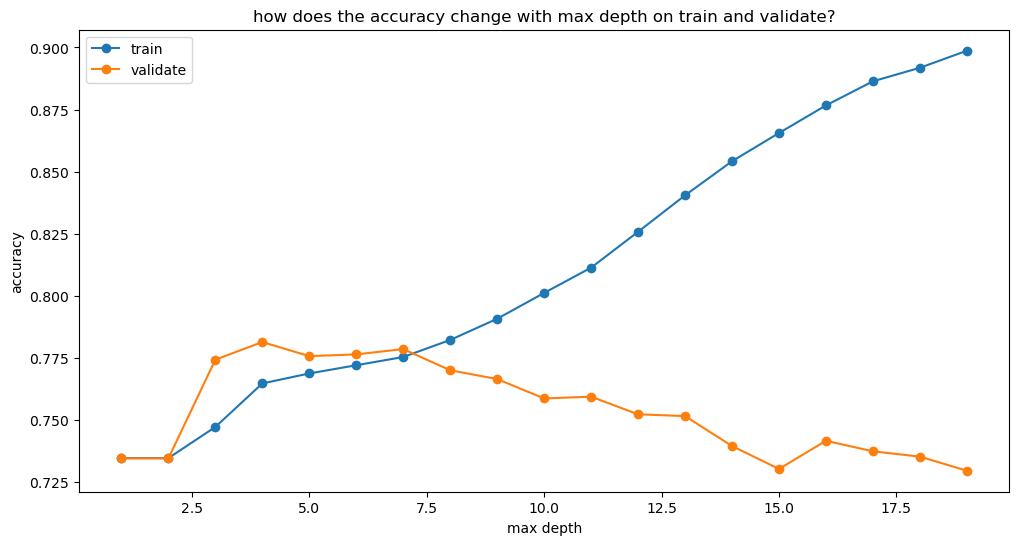

In [12]:
# plots a graph showing comparison of train accuracy, validity accuracy, and the difference between these
plt.figure(figsize=(12,6))
#plots train
plt.plot(scores_df.max_depth, scores_df.train_acc, label='train', marker='o')
#plots validate
plt.plot(scores_df.max_depth, scores_df.val_acc, label='validate', marker='o')
#creates labels and other plot information
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.title('how does the accuracy change with max depth on train and validate?')
plt.legend()
plt.show()

Models 5,6, and 7 perform well on accuracy, but 7 seems to be the most accurate without becoming overfit

In [13]:
# Get accuracy results on test data for model 7
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.72


Model 7 does not seem to perform better than baseline on predicting customer churn

## Conclusions

### Exploration

* Baseline accuracy was 73% 
* Higher monthly charges indicated an elevated likelihood of churn
* Type of contract has a relationship with churn, monthly contracts being especially likely to churn
* Manual billing increases likelihood of churn
* Not having dependents increases lielihood of churn


### Modeling

* The final model does not outperform baseline
* Additional drivers should be added to possibly increase performance


### Recommendations

* Increased incentive to sign longer contracts or to move to automatic billing might help decrease churn rate
* Marketing to families or offering family plan incentives might attract more long term customers

### Next Steps

* Testing other modeling algorithms could be useful to increase predictive capability
* Tenure might also be a useful driver, but we would have to check for relationship between that and monthly charges
* could transform contract type category into monthly vs non-monthly and see if this is a more useful driver